# Network Analysis with NetworkX

In this series of lessons, we're going to learn about network analysis. Network analysis will help us better understand the complex relationships between groups of people, fictional characters, and other kinds of things.

## Dataset: Fase Eliminatória do The International 11

O International é o maior evento de Dota 2 e um dos eventos de e-sports mais bem pagos do mundo.
Nesta análise, verificamos quais equipes e jogadores jogaram mais partidas, como as equipes se saíram umas contra as outras na edição de 2021, bem como medidas de análise de rede, como betweness centrality, weight degree, comunidades, etc.

Organizado pela Valve, esse evento anual reúne as melhores equipes de Dota 2 do mundo para competir pelo título e premiação de milhões de dólares.

## Network Basics

## Install NetworkX

In [22]:
!pip install networkx

## Import Libraries

In [152]:
import os
import networkx
import pandas as pd
#pd.set_option('max_rows', 400)
import matplotlib.pyplot as plt

## Clona o repositório
Nosso dataset se encontra aqui

In [141]:
!git clone https://github.com/TheMatheusDev/network_analysis

fatal: destination path 'network_analysis' already exists and is not an empty directory.


## Coleta nome dos jogadores e seus times

In [156]:
# Dicionário para armazenar os jogadores, seus jogos e times
players = {}

# Diretório contendo os arquivos .csv
dic = 'network_analysis/data/TheInternational/TI_2021/Participating Teams'

# Itera sobre os arquivos .csv no diretório
for arq in os.listdir(dic):
  if arq.endswith(".csv"):
    filepath = os.path.join(dic, arq)

    # Extrai o nome do time do nome do arquivo
    team_name = arq[:-4]

    # Lê o arquivo .csv e adiciona jogadores ao dicionário
    with open(filepath, 'r') as f:
      next(f)
      for line in f:
        player_name = line.strip().split(',')[1]
        if player_name not in players:
          players[player_name] = {'games': 0, 'team': team_name}



## Calcula a quantidade total de partidas de cada jogador

In [157]:
with open('network_analysis/data/TheInternational/TI_2021/Playoffs Main Event Matches.csv', 'r') as f:
  next(f)
  for line in f:
    parts = line.strip().split(',')
    team1 = parts[2].strip()
    score1 = parts[3]
    team2 = parts[4].strip()
    score2 = parts[5]

    qtdPartidas = int(score1) + int(score2)

    # Adiciona a quantidade de partidas
    for player in players:
      if players[player]['team'] == team1 or players[player]['team'] == team2:
        players[player]['games'] += qtdPartidas

## Exibe o dataframe final

In [158]:
df = pd.DataFrame.from_dict(players, orient='index')
df

,games,team
MATUMBAMAN,9,Team Secret
Nisha,9,Team Secret
zai,9,Team Secret
YapzOr,9,Team Secret
Puppey,9,Team Secret
...,...,...
ChYuan,3,Fnatic
Deth,3,Fnatic
Jabz,3,Fnatic
DJ,3,Fnatic


# Eliminatórias: Carrega dataset

In [167]:
df = pd.read_csv('network_analysis/data/TheInternational/TI_2021/Playoffs Main Event Matches.csv', index_col=1)
df

,Unnamed: 0,Team1,Score1,Team2,Score2
Round,,,,,
Upper Bracket R1 (Bo3),0,Invictus Gaming,2,Team Spirit,1
Upper Bracket R1 (Bo3),1,Team Secret,2,OG,0
Upper Bracket R1 (Bo3),2,PSG.LGD,2,T1,1
Upper Bracket R1 (Bo3),3,Virtus.pro,2,Vici Gaming,1
Upper Bracket R2 (Bo3),4,Invictus Gaming,0,Team Secret,2
Upper Bracket R2 (Bo3),5,PSG.LGD,2,Virtus.pro,0
Upper Bracket Final (Bo3),6,Team Secret,0,PSG.LGD,2
Lower Bracket R1 (Bo1),7,Team Undying,0,Fnatic,1
Lower Bracket R1 (Bo1),8,Quincy Crew,1,Team Aster,0


## Cria um grafo direcionado
A seta surge do time vitorioso e aponta para o time que foi derrotado.

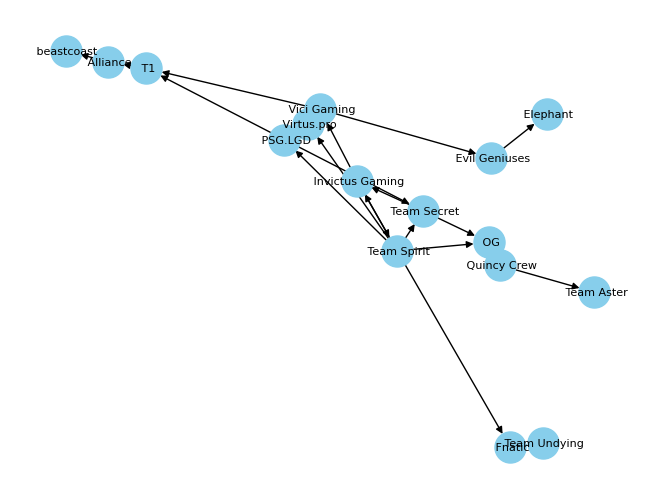

In [164]:
# Cria um grafo direcionado
G = networkx.DiGraph()

# Adiciona nós para cada time
teams = set(df['Team1']).union(set(df['Team2']))
for team in teams:
  G.add_node(team)

# Adiciona arestas representando as partidas vencidas
for index, row in df.iterrows():
  team1 = row['Team1']
  team2 = row['Team2']
  score1 = int(row['Score1'])
  score2 = int(row['Score2'])
  if score1 > score2:
    G.add_edge(team1, team2)
  else:
    G.add_edge(team2, team1)

# Desenha o grafo
networkx.draw(G, with_labels=True, node_size=500, node_color="skyblue", font_size=8)

## Output a Network File

In [165]:
networkx.write_graphml(G, 'TI11 Playoffs Teams.graphml')

## Draw a Simple Network

In [166]:
networkx.degree(G)

DiDegreeView({' Vici Gaming': 4, ' PSG.LGD': 4, ' Quincy Crew': 2, ' beastcoast': 1, ' Team Undying': 1, ' Team Aster': 1, ' Elephant': 1, ' Alliance': 2, ' Team Secret': 4, ' Virtus.pro': 3, ' T1': 3, ' Fnatic': 2, ' Evil Geniuses': 2, ' OG': 3, ' Invictus Gaming': 4, ' Team Spirit': 7})

Make the degree values a `dict`ionary, then add it as a network "attribute" with `networkx.set_node_attributes()`

In [106]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

Make a Pandas dataframe from the degree data `G.nodes(data='degree')`, then sort from highest to lowest

In [107]:
degree_df = pd.DataFrame(G.nodes(data='degree'), columns=['node', 'degree'])
degree_df = degree_df.sort_values(by='degree', ascending=False)
degree_df

,node,degree
15,Team Spirit,7
0,Vici Gaming,4
1,PSG.LGD,4
8,Team Secret,4
14,Invictus Gaming,4
9,Virtus.pro,3
10,T1,3
13,OG,3
2,Quincy Crew,2
7,Alliance,2


Plot the nodes with the highest degree values

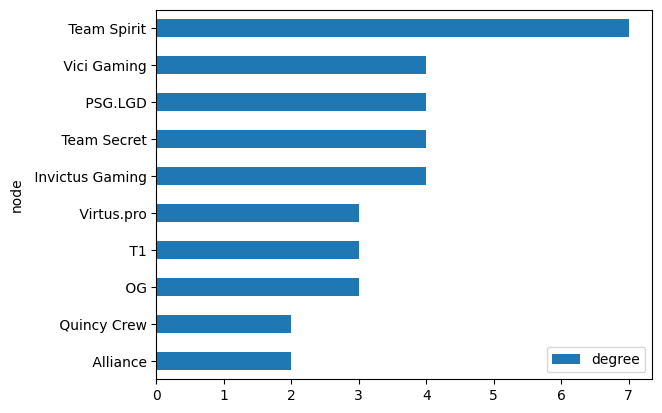

In [108]:
num_nodes_to_inspect = 10
degree_df[:num_nodes_to_inspect].plot(x='node', y='degree', kind='barh').invert_yaxis()

## Calculate Weighted Degree

Who has the most number of connections in the network (if you factor in edge weight)?

In [109]:
networkx.degree(G, weight='Weight')

DiDegreeView({' Vici Gaming': 4, ' PSG.LGD': 4, ' Quincy Crew': 2, ' beastcoast': 1, ' Team Undying': 1, ' Team Aster': 1, ' Elephant': 1, ' Alliance': 2, ' Team Secret': 4, ' Virtus.pro': 3, ' T1': 3, ' Fnatic': 2, ' Evil Geniuses': 2, ' OG': 3, ' Invictus Gaming': 4, ' Team Spirit': 7})

Make the weighted degree values a `dict`ionary, then add it as a network "attribute" with `networkx.set_node_attributes()`

In [110]:
weighted_degrees = dict(networkx.degree(G, weight='Weight'))
networkx.set_node_attributes(G, name='weighted_degree', values=weighted_degrees)

Make a Pandas dataframe from the degree data `G.nodes(data='weighted_degree')`, then sort from highest to lowest

In [111]:
weighted_degree_df = pd.DataFrame(G.nodes(data='weighted_degree'), columns=['node', 'weighted_degree'])
weighted_degree_df = weighted_degree_df.sort_values(by='weighted_degree', ascending=False)
weighted_degree_df

,node,weighted_degree
15,Team Spirit,7
0,Vici Gaming,4
1,PSG.LGD,4
8,Team Secret,4
14,Invictus Gaming,4
9,Virtus.pro,3
10,T1,3
13,OG,3
2,Quincy Crew,2
7,Alliance,2


Plot the nodes with the highest weighted degree values

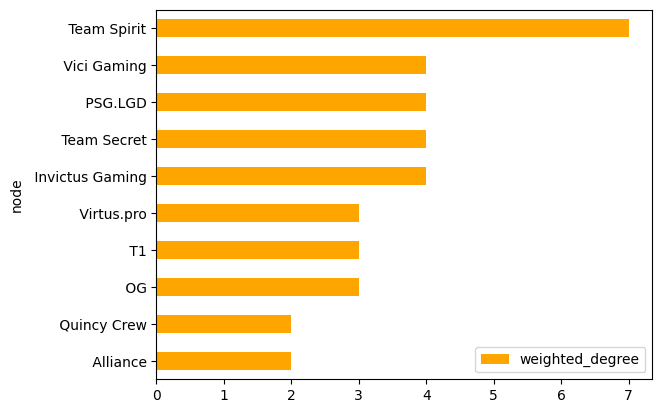

In [112]:
num_nodes_to_inspect = 10
weighted_degree_df[:num_nodes_to_inspect].plot(x='node', y='weighted_degree', color='orange', kind='barh').invert_yaxis()

## Calculate Betweenness Centrality Scores

Who connects the most other nodes in the network?

In [113]:
networkx.betweenness_centrality(G)

{' Vici Gaming': 0.09047619047619049,
 ' PSG.LGD': 0.014285714285714287,
 ' Quincy Crew': 0.02380952380952381,
 ' beastcoast': 0.0,
 ' Team Undying': 0.0,
 ' Team Aster': 0.0,
 ' Elephant': 0.0,
 ' Alliance': 0.03333333333333334,
 ' Team Secret': 0.03333333333333334,
 ' Virtus.pro': 0.02142857142857143,
 ' T1': 0.05714285714285715,
 ' Fnatic': 0.01904761904761905,
 ' Evil Geniuses': 0.028571428571428574,
 ' OG': 0.0380952380952381,
 ' Invictus Gaming': 0.07380952380952381,
 ' Team Spirit': 0.06666666666666668}

In [114]:
betweenness_centrality = networkx.betweenness_centrality(G)

Add `betweenness_centrality` (which is already a dictionary) as a network "attribute" with `networkx.set_node_attributes()`

In [115]:
networkx.set_node_attributes(G, name='betweenness', values=betweenness_centrality)

Make a Pandas dataframe from the betweenness data `G.nodes(data='betweenness')`, then sort from highest to lowest

In [116]:
betweenness_df = pd.DataFrame(G.nodes(data='betweenness'), columns=['node', 'betweenness'])
betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)
betweenness_df

,node,betweenness
0,Vici Gaming,0.090476
14,Invictus Gaming,0.073810
15,Team Spirit,0.066667
10,T1,0.057143
13,OG,0.038095
7,Alliance,0.033333
8,Team Secret,0.033333
12,Evil Geniuses,0.028571
2,Quincy Crew,0.023810
9,Virtus.pro,0.021429


Plot the nodes with the highest betweenness centrality scores

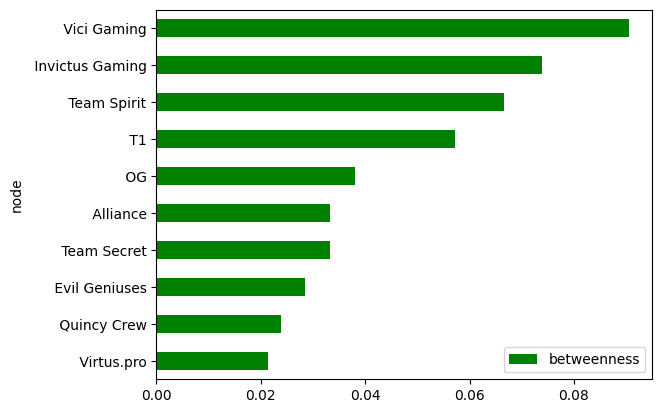

In [117]:
num_nodes_to_inspect = 10
betweenness_df[:num_nodes_to_inspect].plot(x='node', y='betweenness', color='green', kind='barh').invert_yaxis()

## Communities

Who forms distinct communities within this network?

In [118]:
from networkx.algorithms import community

Calculate communities with `community.greedy_modularity_communities()`

In [119]:
communities = community.greedy_modularity_communities(G)

In [120]:
communities

[frozenset({' Alliance',
            ' Elephant',
            ' Evil Geniuses',
            ' T1',
            ' Vici Gaming',
            ' beastcoast'}),
 frozenset({' Invictus Gaming',
            ' OG',
            ' PSG.LGD',
            ' Team Secret',
            ' Team Spirit',
            ' Virtus.pro'}),
 frozenset({' Fnatic', ' Team Undying'}),
 frozenset({' Quincy Crew', ' Team Aster'})]

Make a `dict`ionary by looping through the communities and, for each member of the community, adding their community number

In [121]:
# Create empty dictionary
modularity_class = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number
    for name in community:
        modularity_class[name] = community_number

Add modularity class to the network as an attribute

In [122]:
networkx.set_node_attributes(G, modularity_class, 'modularity_class')

Make a Pandas dataframe from modularity class network data `G.nodes(data='modularity_class')`

In [123]:
communities_df = pd.DataFrame(G.nodes(data='modularity_class'), columns=['node', 'modularity_class'])
communities_df = communities_df.sort_values(by='modularity_class', ascending=False)

In [124]:
communities_df

,node,modularity_class
2,Quincy Crew,3
5,Team Aster,3
4,Team Undying,2
11,Fnatic,2
1,PSG.LGD,1
8,Team Secret,1
9,Virtus.pro,1
13,OG,1
14,Invictus Gaming,1
15,Team Spirit,1


Inspect each community in the network

In [127]:
communities_df[communities_df['modularity_class'] == 3]

,node,modularity_class
2,Quincy Crew,3
5,Team Aster,3


In [128]:
communities_df[communities_df['modularity_class'] == 2]

,node,modularity_class
4,Team Undying,2
11,Fnatic,2


In [129]:
communities_df[communities_df['modularity_class'] == 1]

,node,modularity_class
1,PSG.LGD,1
8,Team Secret,1
9,Virtus.pro,1
13,OG,1
14,Invictus Gaming,1
15,Team Spirit,1


In [130]:
communities_df[communities_df['modularity_class'] == 0]

,node,modularity_class
0,Vici Gaming,0
3,beastcoast,0
6,Elephant,0
7,Alliance,0
10,T1,0
12,Evil Geniuses,0


Plot a sample of 40 characters with their modularity class indicated by a star

In [131]:
import seaborn as sns

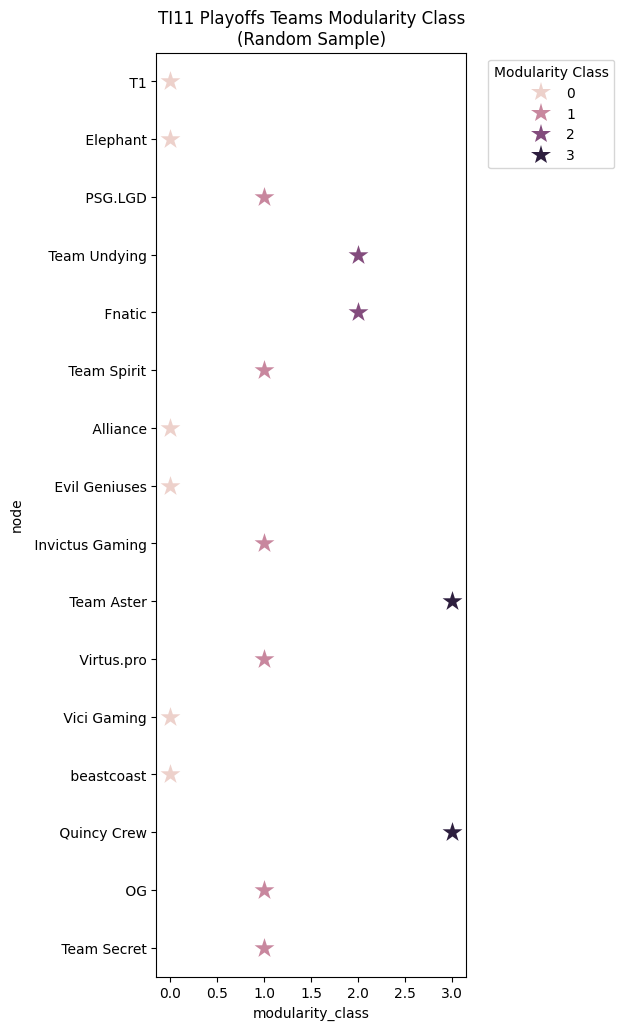

In [135]:
#Set figure size
plt.figure(figsize=(4,12))

#Plot a categorical scatter plot from the dataframe communities_df.sample(16)
ax =sns.stripplot(x='modularity_class', y='node', data=communities_df.sample(16),
              hue='modularity_class', marker='*',size=15)
#Set legend outside the plot with bbox_to_anchor
ax.legend(loc='upper right',bbox_to_anchor=(1.5, 1), title='Modularity Class')
ax.set_title("TI11 Playoffs Teams Modularity Class\n(Random Sample)")
plt.show()

Plot all GOT characters with their modularity class indicated by a star (tak

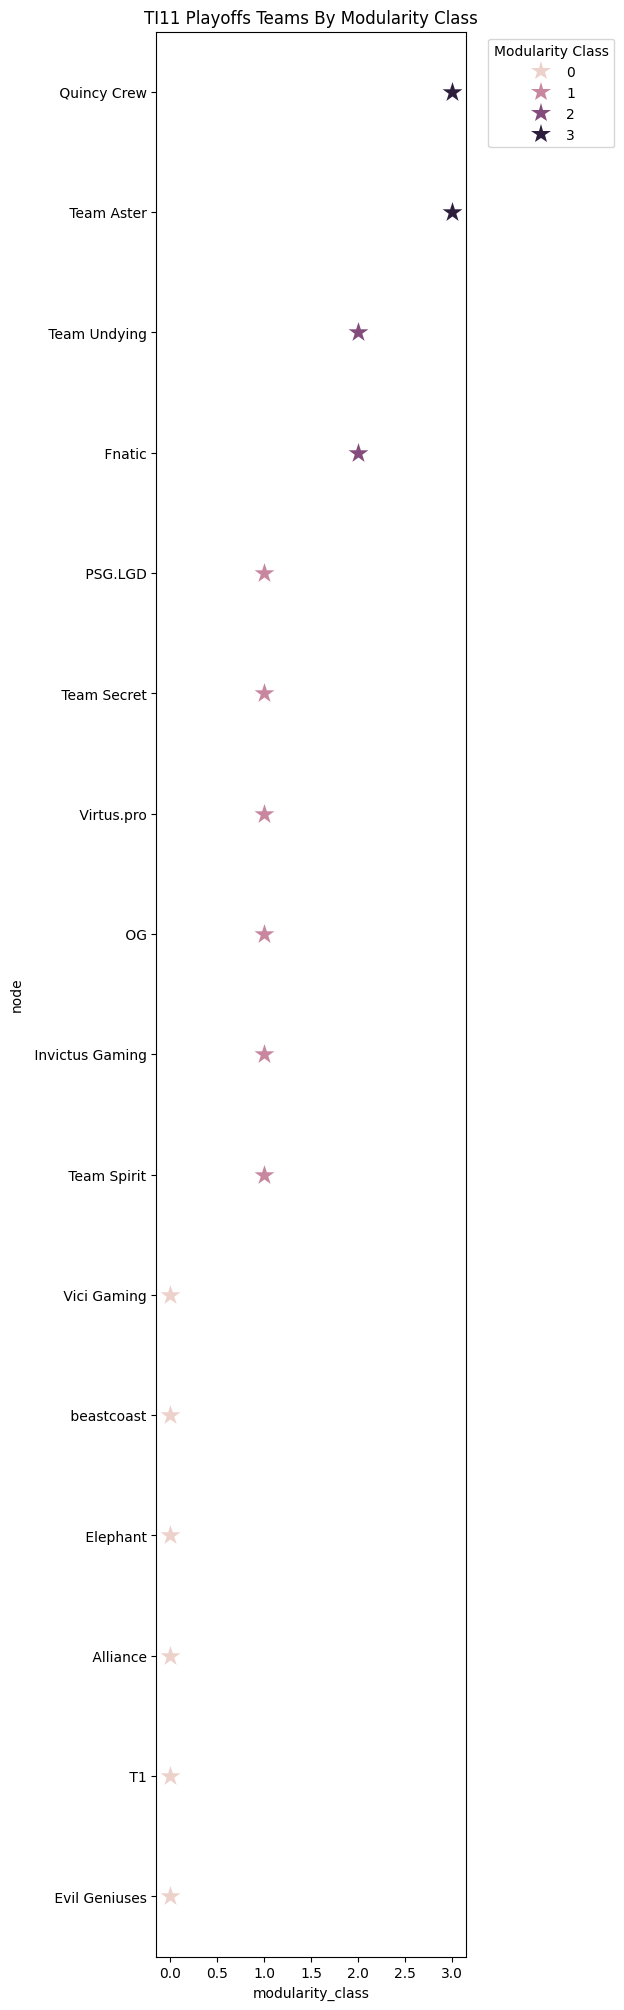

In [136]:
plt.figure(figsize=(4,25))

ax =sns.stripplot(x='modularity_class', y='node', data=communities_df,
              hue='modularity_class', marker='*',size=15)

ax.legend(loc='upper right',bbox_to_anchor=(1.5, 1), title='Modularity Class')
ax.set_title("TI11 Playoffs Teams By Modularity Class")
plt.show()

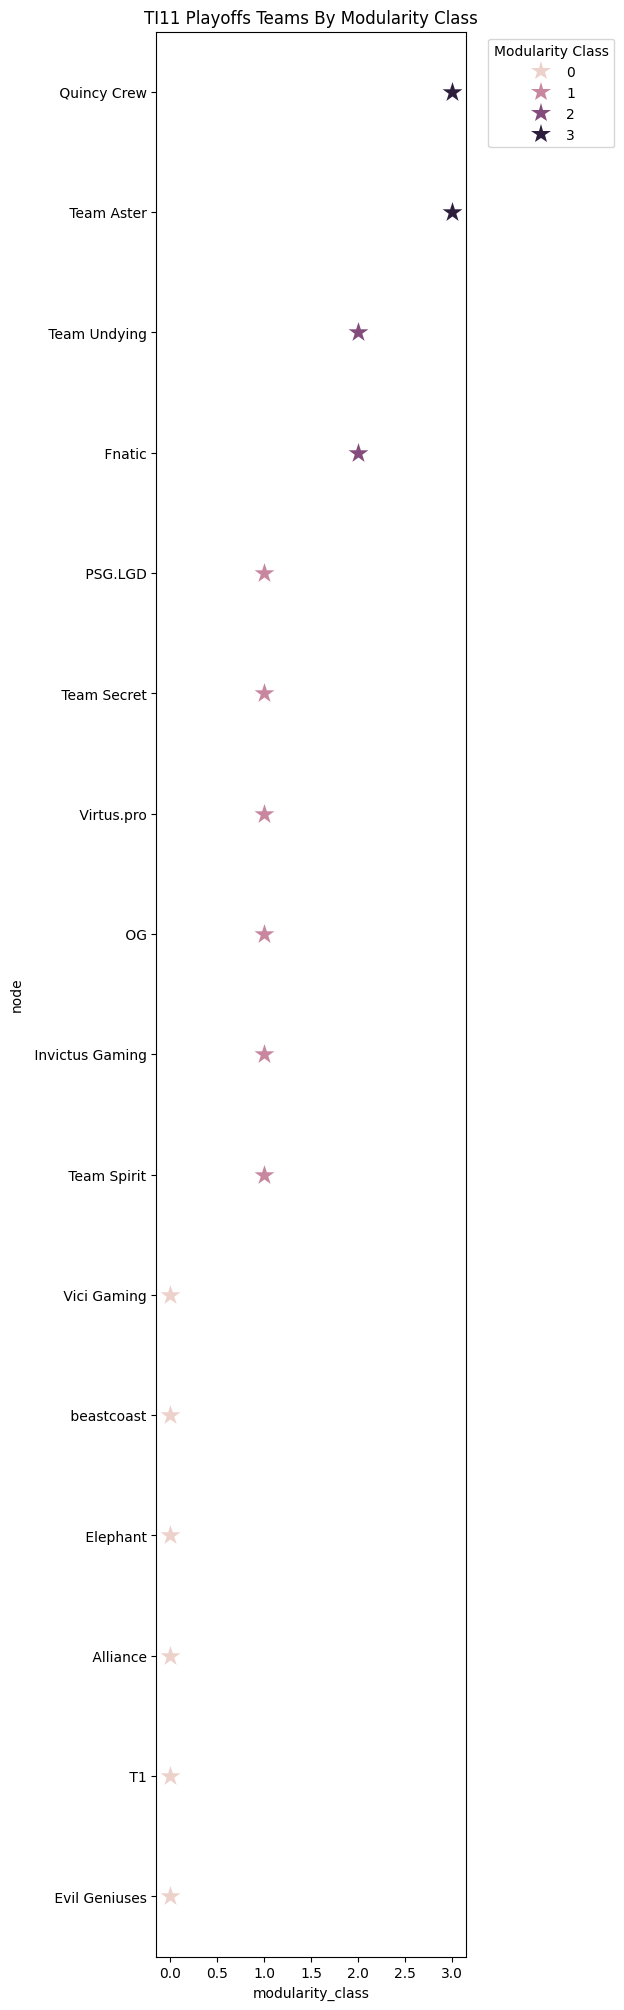

In [137]:
plt.figure(figsize=(4,25))

ax =sns.stripplot(x='modularity_class', y='node', data=communities_df,
              hue='modularity_class', marker='*',size=15)

ax.legend(loc='upper right',bbox_to_anchor=(1.5, 1), title='Modularity Class')
ax.set_title("TI11 Playoffs Teams By Modularity Class")
plt.show()

## All Network Metrics

Create a Pandas dataframe of all network attributes by creating a `dict`ionary of `G.nodes(data=True)`...

In [138]:
dict(G.nodes(data=True))

{' Vici Gaming': {'degree': 4,
  'weighted_degree': 4,
  'betweenness': 0.09047619047619049,
  'modularity_class': 0},
 ' PSG.LGD': {'degree': 4,
  'weighted_degree': 4,
  'betweenness': 0.014285714285714287,
  'modularity_class': 1},
 ' Quincy Crew': {'degree': 2,
  'weighted_degree': 2,
  'betweenness': 0.02380952380952381,
  'modularity_class': 3},
 ' beastcoast': {'degree': 1,
  'weighted_degree': 1,
  'betweenness': 0.0,
  'modularity_class': 0},
 ' Team Undying': {'degree': 1,
  'weighted_degree': 1,
  'betweenness': 0.0,
  'modularity_class': 2},
 ' Team Aster': {'degree': 1,
  'weighted_degree': 1,
  'betweenness': 0.0,
  'modularity_class': 3},
 ' Elephant': {'degree': 1,
  'weighted_degree': 1,
  'betweenness': 0.0,
  'modularity_class': 0},
 ' Alliance': {'degree': 2,
  'weighted_degree': 2,
  'betweenness': 0.03333333333333334,
  'modularity_class': 0},
 ' Team Secret': {'degree': 4,
  'weighted_degree': 4,
  'betweenness': 0.03333333333333334,
  'modularity_class': 1},
 ' 

...and then [transposing it](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.T.html) (flipping the columns and rows) with `.T`

In [139]:
nodes_df = pd.DataFrame(dict(G.nodes(data=True))).T
nodes_df

,degree,weighted_degree,betweenness,modularity_class
Vici Gaming,4.0,4.0,0.090476,0.0
PSG.LGD,4.0,4.0,0.014286,1.0
Quincy Crew,2.0,2.0,0.023810,3.0
beastcoast,1.0,1.0,0.000000,0.0
Team Undying,1.0,1.0,0.000000,2.0
Team Aster,1.0,1.0,0.000000,3.0
Elephant,1.0,1.0,0.000000,0.0
Alliance,2.0,2.0,0.033333,0.0
Team Secret,4.0,4.0,0.033333,1.0
Virtus.pro,3.0,3.0,0.021429,1.0


In [140]:
nodes_df.sort_values(by='betweenness', ascending=False)

,degree,weighted_degree,betweenness,modularity_class
Vici Gaming,4.0,4.0,0.090476,0.0
Invictus Gaming,4.0,4.0,0.073810,1.0
Team Spirit,7.0,7.0,0.066667,1.0
T1,3.0,3.0,0.057143,0.0
OG,3.0,3.0,0.038095,1.0
Alliance,2.0,2.0,0.033333,0.0
Team Secret,4.0,4.0,0.033333,1.0
Evil Geniuses,2.0,2.0,0.028571,0.0
Quincy Crew,2.0,2.0,0.023810,3.0
Virtus.pro,3.0,3.0,0.021429,1.0
